# **Final project: Google Maps review sentiment classification**


# **Authors:** Aleksandra Dmitruka,  Markuss Birznieks

# **1.Loading needed libraries, files setting flags**

## 1.1.Importing needed libraries

In [ ]:
# Standard libraries
import random
from collections import Counter, defaultdict

# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn
from tabulate import tabulate

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# PyTorch core
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch data utilities
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils import data

# Hugging Face Transformers
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from huggingface_hub import notebook_login

# Miscellaneous
from tqdm import tqdm
import requests
import ipywidgets as widgets
from IPython.display import display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2. Downloading collected reviews, setting data path

In [ ]:
# Our collected reviews via google-maps-reviews-scrapper
# https://github.com/YasogaN/google-maps-review-scraper

!wget https://raw.githubusercontent.com/Markuss-B/google-maps-review-model/refs/heads/main/data/reviews.jsonl

--2025-06-25 17:58:10--  https://raw.githubusercontent.com/Markuss-B/google-maps-review-model/refs/heads/main/data/reviews.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35639302 (34M) [text/plain]
Saving to: ‘reviews.jsonl.4’

reviews.jsonl.4     100%[===================>]  33.99M  94.7MB/s    in 0.4s    

2025-06-25 17:58:10 (94.7 MB/s) - ‘reviews.jsonl.4’ saved [35639302/35639302]



In [ ]:
DATA_PATH = "reviews.jsonl"

## 1.3.Setting flags to control notebook execution

### 1.3.1. Train data separation flags

In [ ]:
# Data modes
# only one datamode at a time can be selected !!!

# Take full dataset of 100k reviews collected and 1-5 stars
FULL_SET = False

#Use sampler to ease the learining process, otherwise - cut 25k for training, 5k for test
SAMPLER = False and FULL_SET

#Use simplified labels - positive(2), neutral(1), negative(0)
THREE_CLASS = False

### 1.3.2. Training and tokinezation flags flags

In [ ]:
# Do we want to train at all
TRAIN = False

# finetune nlp-town bert model for 5 classes(1-5 stars)
TRAIN_BERT = False

# train distilbert from scratch for 5 classes(1-5 stars)
TRAIN_DISTILBERT = False

# train our handmade lstm model for 5 classes(1-5 stars)
TRAIN_RNN = False

# train distilbert from scratch for 3 classes (pos,neut,neg)
TRAIN_3CLASS_DISTILBERT=False

# train our handmade lstm from scratch for 3 classes (pos,neut,neg)
TRAIN_3CLASS_RNN=False

In [ ]:
# Setting to false to avoid repeating tokinezation
TOKENIZE = True

### 1.3.3. Evaluation flags

In [ ]:
# Do we want to evaluate models at all
EVAL_MODE = True
SET_25=True
EXTRA_TEST=False

In [ ]:
# Which datamode models do we want
if EVAL_MODE:
    if SAMPLER or EXTRA_TEST:
        RNN_PATH_SAMPLER = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/rnn_sampler_0.5063.pt"
        BERT_PATH_SAMPLER = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/bert_sampler_0.5256.pt"
        DISTILBERT_PATH_SAMPLER = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/distilbert_sampler_0.5509.pt"
    if FULL_SET or EXTRA_TEST:
        RNN_PATH_FULLSET = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/rnn_fullset_0.5186.pt"
        BERT_PATH_FULLSET = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/bert_fullset_0.5205.pt"
        DISTILBERT_PATH_FULLSET = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/distilbert_fullset_0.5572.pt"
    if THREE_CLASS:
        RNN_PATH_THREE_CLASS = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/rnn_3class_0.7361.pt"
        DISTILBERT_PATH_THREE_CLASS = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/distilbert_3class_0.7834.pt"
        BERT_PATH_THREE_CLASS = None  # not used
    if SET_25 or EXTRA_TEST:
        RNN_PATH_SET_25 = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/rnn_25set_0.5056.pt"
        BERT_PATH_SET_25 = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/bert_25set_0.5550.pt"
        DISTILBERT_PATH_SET_25 = "https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/distilbert_25set_0.5819.pt"

# **2.Methods and classes for dataset creation, models creation/training/validation**

## 2.1. Bert (NLP-Town) and DistilBert (standart, not trained) model classes

In [ ]:
class DistilBertModel(nn.Module):
    # See documentation: https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertForSequenceClassification

    def __init__(self, model_name="distilbert-base-uncased", num_labels=5):
        """
        Initializes the DistilBERT model for sequence classification.

        Args:
            model_name (str): Name of the DistilBERT model to load.
            num_labels (int): Number of output labels for classification.
        """
        super().__init__()
        self.model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

In [ ]:
class BertModel(nn.Module):
    def __init__(self, freeze=True):
        """
        Initializes a BERT-based sentiment classification model.

        Args:
            freeze (bool): If True, freezes most of the BERT layers and only fine-tunes
                           the classification head.
        """
        super().__init__()

        # Optional: logs in to Hugging Face to suppress model download warnings in notebooks
        notebook_login()

        # Load pretrained BERT model for sentiment analysis
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "nlptown/bert-base-multilingual-uncased-sentiment"
        )

        # Optionally freeze most of the model's weights
        if freeze:
            # Freeze all parameters
            for param in self.model.parameters():
                param.requires_grad = False

            # Unfreeze only classifier and pre_classifier layers
            for name, param in self.model.named_parameters():
                if 'classifier' in name or 'pre_classifier' in name:
                    param.requires_grad = True

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


## 2.2. Custom LSTM model class

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        """
        Initializes an LSTM-based sequence model.

        Args:
            num_emb (int): Size of the vocabulary (number of unique tokens).
            output_size (int): Number of output classes (for classification).
            num_layers (int): Number of LSTM layers.
            hidden_size (int): Size of the hidden state vectors.
        """
        super(LSTM, self).__init__()

        # Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size, padding_idx=0)

        # LSTM layer(s) to process the sequence of embeddings
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5  # Applies dropout to outputs of each LSTM layer (except last)
        )

        # Fully connected layer to project the final hidden state to output size
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        """
        Forward pass of the LSTM model.

        Args:
            input_seq (torch.Tensor): Input sequence of token indices (batch_size, seq_len).
            hidden_in (torch.Tensor): Initial hidden state(s) for the LSTM (num_layers, batch_size, hidden_size).
            mem_in (torch.Tensor): Initial cell state(s) for the LSTM (num_layers, batch_size, hidden_size).

        Returns:
            output_logits (torch.Tensor): Class scores for each token in the sequence (batch_size, seq_len, output_size).
            hidden_out (torch.Tensor): Final hidden state from the LSTM.
            mem_out (torch.Tensor): Final cell state from the LSTM.
        """
        # Convert input indices to embeddings
        input_embs = self.embedding(input_seq)

        # Pass embeddings through the LSTM
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))

        # Project LSTM outputs to class logits
        return self.fc_out(output), hidden_out, mem_out


## 2.2. Review dataset classes

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, tokenized_texts, raw_texts, labels, places):
        """
        Custom PyTorch Dataset for handling text reviews and associated metadata.

        Args:
            tokenized_texts (dict): Dictionary containing tokenized inputs (input_ids and attention_mask).
            raw_texts (List[str]): List of raw review texts (before tokenization).
            labels (List[int]): List of target labels for each review.
            places (List[str]): List of associated place/location for each review.
        """
        self.tokenized_texts = tokenized_texts
        self.raw_texts = raw_texts
        self.labels = labels
        self.places = places

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves tokenized input data and label for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            input_ids (torch.Tensor): Tensor of token IDs for the sample.
            attention_mask (torch.Tensor): Tensor indicating which tokens are padding.
            label (torch.Tensor): Ground truth label for the sample.
        """
        # Extract tokenized inputs for the current index
        input_ids = self.tokenized_texts['input_ids'][idx]
        attention_mask = self.tokenized_texts['attention_mask'][idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return input_ids, attention_mask, label

    def get_place(self, idx):
        """
        Returns the place/location associated with a given sample.

        Args:
            idx (int): Index of the sample.

        Returns:
            str: Place associated with the review.
        """
        return self.places[idx]

    def get_raw_text(self, idx):
        """
        Returns the raw (untokenized) review text for a given sample.

        Args:
            idx (int): Index of the sample.

        Returns:
            str: Raw text of the review.
        """
        return self.raw_texts[idx]

In [ ]:
class RnnDataset(Dataset):
    def __init__(self, input_ids, labels):
        """
        Custom PyTorch Dataset for RNN-based models.

        Args:
            input_ids (List[torch.Tensor] or torch.Tensor): Sequences of token indices.
            labels (List[int] or torch.Tensor): Corresponding labels for each sequence.
        """
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves input and label for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            input_ids (torch.Tensor): Token indices for the sample.
            label (int or torch.Tensor): Ground truth label for the sample.
        """
        return self.input_ids[idx], self.labels[idx]


# 2.3. Dataset split methods

## 2.3.1. Equal class splitting method



In [ ]:
def split_equal(labels, texts, places, train_per_class, val_per_class, test_per_class):
    """
    Splits the dataset into balanced train, validation, and test sets based on class labels.

    Args:
        labels (List[int]): List of class labels for each sample.
        texts (List[str]): List of text samples.
        places (List[str]): List of associated place/location for each sample.
        train_per_class (int): Number of samples per class for the training set.
        val_per_class (int): Number of samples per class for the validation set.
        test_per_class (int): Number of samples per class for the test set.

    Returns:
        Tuple of 9 lists:
            texts_train, places_train, labels_train,
            texts_val, places_val, labels_val,
            texts_test, places_test, labels_test
    """
    # Group sample indices by label
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    # Desired samples per class
    train_per_class = train_per_class
    val_per_class = val_per_class
    test_per_class = test_per_class

    train_indices = []
    val_indices = []
    test_indices = []

    # Ensure reproducibility
    np.random.seed(42)

    # Create balanced splits per class
    for label, indices in label_to_indices.items():
       # Check if there are enough samples for the class
        if len(indices) < train_per_class + val_per_class + test_per_class:
            raise ValueError(f"Not enough samples for class {label + 1}")

        shuffled = np.random.permutation(indices)
        train = shuffled[:train_per_class]
        val = shuffled[train_per_class:train_per_class + val_per_class]
        test = shuffled[train_per_class + val_per_class:train_per_class + val_per_class + test_per_class]

        train_indices.extend(train)
        val_indices.extend(val)
        test_indices.extend(test)

    # Apply splits to data
    texts_train = [texts[i] for i in train_indices]
    places_train = [places[i] for i in train_indices]
    labels_train = [labels[i] for i in train_indices]

    texts_val = [texts[i] for i in val_indices]
    places_val = [places[i] for i in val_indices]
    labels_val = [labels[i] for i in val_indices]

    texts_test = [texts[i] for i in test_indices]
    places_test = [places[i] for i in test_indices]
    labels_test = [labels[i] for i in test_indices]

    return texts_train, places_train, labels_train, texts_val, places_val, labels_val, texts_test, places_test, labels_test

## 2.3.2. 25k train dataset splitting method

In [ ]:
def split_25_5_5(labels, texts, places):
    """
    Convenience wrapper for `split_equal()` to create a fixed-size split:
    - 5000 samples per class for training (25k for 5 classes)
    - 1000 samples per class for validation
    - 1000 samples per class for testing

    Args:
        labels (List[int]): Original class labels (1-based).
        texts (List[str]): List of review texts.
        places (List[str]): List of associated place/location data.

    Returns:
        Tuple of 9 lists:
            texts_train, places_train, labels_train,
            texts_val, places_val, labels_val,
            texts_test, places_test, labels_test
    """

    # Convert labels from 1-based to 0-based indexing
    labels = [label - 1 for label in labels]

    # Call split_equal with fixed per-class sample sizes
    return split_equal(
        labels,
        texts,
        places,
        train_per_class=5000,
        val_per_class=1000,
        test_per_class=1000
    )

## 2.3.3. 3-class splitting method

In [ ]:
def map_labels_3class(labels):
    """
    Maps original 5-class sentiment labels into 3 classes:
        - 0: Negative (original labels 1 or 2)
        - 1: Positive (original labels 4 or 5)
        - 2: Neutral (original label 3)

    Args:
        labels (List[int]): Original 1–5 scale sentiment labels.

    Returns:
        List[int]: Mapped labels in the range [0, 1, 2].
    """
    return [0 if label <= 2 else 1 if label >= 4 else 2 for label in labels]


def split_3class(labels, texts, places):
    """
    Maps sentiment labels to 3 classes and splits the dataset into balanced train/val/test sets:
        - 9000 samples per class for training
        - 1000 samples per class for validation
        - 1000 samples per class for testing

    Args:
        labels (List[int]): Original 1–5 sentiment labels.
        texts (List[str]): List of review texts.
        places (List[str]): List of place/location data.

    Returns:
        Tuple of 9 lists:
            texts_train, places_train, labels_train,
            texts_val, places_val, labels_val,
            texts_test, places_test, labels_test
    """
    # Convert original 5-class labels to 3-class
    labels = map_labels_3class(labels)

    # Use balanced splitting based on mapped labels
    return split_equal(
        labels,
        texts,
        places,
        train_per_class=9000,
        val_per_class=1000,
        test_per_class=1000
    )

## 2.3.4. Dataset sampler method

In [ ]:
def createSampler(labels, num_samples=25000, replacement=True):
    """
    Creates a WeightedRandomSampler to address class imbalance during training.

    Args:
        labels (List[int] or torch.Tensor): List of class labels for the dataset.
        num_samples (int): Number of samples to draw per epoch.
        replacement (bool): Whether sampling is done with replacement.

    Returns:
        WeightedRandomSampler: Sampler that can be passed to a DataLoader.
    """

    # Count number of samples per class
    class_sample_count = pd.Series(labels).value_counts().sort_index().values

    # Compute class weights: inverse of class frequency
    # This gives higher weight to underrepresented classes
    weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)

    # Assign weight to each sample based on its class
    sample_weights = weights[labels]

    # Create sampler that draws samples with probability proportional to their weight
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=num_samples,  # Total number of samples to draw per epoch
        replacement=replacement    # If True, allows repeated sampling of the same item
    )

    return sampler

## 2.4. Data analysis/vizualization methods

### 2.4.1. Checking dataframe for multiple whitespaces/empty rows

In [ ]:
def check_bad_rows(df, text_column='text'):
    """
    Checks for problematic rows in a DataFrame's text column.

    Specifically, it finds:
      - Rows where the text is empty or only whitespace.
      - Rows containing multiple consecutive spaces or newlines.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): Name of the column with text to check.

    Prints:
        Number of empty rows and rows with multiple spaces/newlines.
    """
    empty_rows = df[df[text_column].str.strip() == '']

    # Find rows containing two or more consecutive whitespace characters (spaces, tabs, newlines)
    multi_space_rows = df[df[text_column].str.contains(r'\s{2,}', na=False)]

    print(f"Empty rows found: {len(empty_rows)}")

    print(f"\nRows with multiple spaces/newlines: {len(multi_space_rows)}")

### 2.4.2. Data examples pretty pringing

In [ ]:
def print_examples(df, n=5):
    """
    Prints the first n rows of a DataFrame in a nicely formatted table.

    Args:
        df (pd.DataFrame): DataFrame containing the data to display.
        n (int): Number of rows to print from the top of the DataFrame.
    """
    df_sample = df.head(n).copy()

    align = {}
    for col in df_sample.columns:
        if col == 'text':
            align[col] = 'left'
        else:
            align[col] = 'center'

    print(tabulate(
        df_sample,
        headers='keys',
        tablefmt='fancy_grid',
        showindex=False,
        colalign=[align[col] for col in df_sample.columns]
    ))

### 2.4.3. Whole dataset distribution of lables

In [ ]:
def print_label_distribution(labels):
    """
    Prints the distribution of labels in a dataset as a formatted table.

    Args:
        labels (List[int] or List[str]): List of class labels.
    """
    total = len(labels)
    counts = Counter(labels)
    labels_sorted = sorted(counts)

    table = []
    for label in labels_sorted:
        count = counts[label]
        percent = (count / total) * 100
        table.append([label, count, f"{percent:.2f}%"])

    table.append(["Total", total, "100.00%"])

    print(tabulate(table, headers=["Label", "Count", "Percentage"], tablefmt="fancy_grid"))

### 2.4.4. Total data discribution plotting for train/val/test

In [ ]:
def plot_label_distributions(train_counts, val_counts, test_counts, title="Label Distribution in Train/Val/Test"):
    """
    Plots side-by-side bar charts showing label counts for train, validation, and test sets.

    Args:
        train_counts (dict): Dictionary mapping labels to counts in the training set.
        val_counts (dict): Dictionary mapping labels to counts in the validation set.
        test_counts (dict): Dictionary mapping labels to counts in the test set.
        title (str): Title of the plot.
    """

    # Get all unique labels present across train, val, and test sets
    all_labels = sorted(set(train_counts) | set(val_counts) | set(test_counts))

    # Extract counts for each label; default to 0 if label not present in a split
    train_values = [train_counts.get(label, 0) for label in all_labels]
    val_values = [val_counts.get(label, 0) for label in all_labels]
    test_values = [test_counts.get(label, 0) for label in all_labels]

    x = np.arange(len(all_labels))  # label positions on the x-axis
    width = 0.25  # width of each bar

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for each dataset, offsetting their positions to avoid overlap
    bars_train = ax.bar(x - width, train_values, width, label='Train', color='lightblue', edgecolor='black')
    bars_val = ax.bar(x, val_values, width, label='Validation', color='salmon', edgecolor='black')
    bars_test = ax.bar(x + width, test_values, width, label='Test', color='lightgreen', edgecolor='black')

    # Set axis labels and title
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels)
    ax.legend()

    # Function to add count labels above each bar for clarity
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=8
            )

    # Add labels to all bars
    autolabel(bars_train)
    autolabel(bars_val)
    autolabel(bars_test)

    plt.tight_layout()
    plt.show()


### 2.4.5. Text length distribution for individual dataset

In [ ]:
def plot_avg_length_by_rating(texts, labels, split_name):
    """
    Plots the average number of words per review grouped by rating for a given dataset split,
    showing only integer ratings on the x-axis.

    Args:
        texts (List[str]): List of review texts.
        labels (List[int] or List[float]): Corresponding list of ratings/labels.
        split_name (str): Name of the dataset split (e.g., 'Train', 'Validation', 'Test') to display in the title.
    """
    df = pd.DataFrame({'text': texts, 'rating': labels})
    df['length'] = df['text'].apply(lambda x: len(x.split()))
    avg_length = df.groupby('rating')['length'].mean()

    plt.figure(figsize=(8, 5))
    bars = plt.bar(avg_length.index, avg_length.values, color='lightgreen', edgecolor='black')
    plt.title(f'Average review length by rating - {split_name}')
    plt.xlabel('Rating')
    plt.ylabel('Average number of words')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Set x-axis ticks to be exactly the integer rating values
    plt.xticks(ticks=avg_length.index, labels=[str(int(r)) for r in avg_length.index])

    plt.tight_layout()
    plt.show()

### 2.4.6. Reviews per place (top N, for individual dataset)

In [ ]:
def plot_reviews_per_place(places, split_name, top_n=20):
    """
    Plots a horizontal bar chart showing the top N places by number of reviews.

    Args:
        places (List[str]): List of place names corresponding to reviews.
        split_name (str): Name of the dataset split (e.g., 'Train', 'Validation', 'Test') to display in the title.
        top_n (int, optional): Number of top places to display. Defaults to 20.
    """
    # Count the occurrences of each place
    place_counts = Counter(places)

    most_common = place_counts.most_common(top_n)
    places_list, counts_list = zip(*most_common)  # unzip into separate lists

    plt.figure(figsize=(10, 6))
    # Plot horizontal bars; reverse to have the highest count at the top
    plt.barh(places_list[::-1], counts_list[::-1], color='salmon', edgecolor='black')
    plt.title(f'Top {top_n} Places by number of reviews - {split_name}')
    plt.xlabel('Number of reviews')
    plt.ylabel('Place')
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # vertical grid lines
    plt.tight_layout()
    plt.show()

### 2.4.7. Top words per individual dataset (stopwords excluded)

In [ ]:
stop_words = set(stopwords.words('english'))
def print_top_words_per_rating(texts, labels, stop_words, top_n=10):
    """
    Prints the top N most frequent words for each rating, excluding stopwords.

    Args:
        texts (List[str]): List of review texts.
        labels (List[int] or List[str]): Corresponding list of ratings/labels.
        stop_words (set): Set of words to exclude (e.g., common stopwords).
        top_n (int, optional): Number of top words to display per rating. Default is 10.
    """
    grouped_texts = defaultdict(list)
    for text, label in zip(texts, labels):
        grouped_texts[label].append(text)

    rating_top_words = {}
    for rating, texts_list in grouped_texts.items():
        all_words = ' '.join(texts_list).lower().split()
        filtered_words = [w for w in all_words if w not in stop_words]
        word_counts = Counter(filtered_words)
        rating_top_words[rating] = word_counts.most_common(top_n)

    sorted_ratings = sorted(rating_top_words.keys())

    rows = []
    for i in range(top_n):
        row = []
        for rating in sorted_ratings:
            try:
                word, count = rating_top_words[rating][i]
                row.append(f"{word} ({count})")
            except IndexError:
                row.append("")
        rows.append(row)

    headers = [f"Rating {r}" for r in sorted_ratings]
    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

## 2.5. Training methods

### 2.5.1. Tokinezation methods

In [ ]:
def tokenize_texts(texts, tokenizer, max_length=128):
    """
    Tokenizes a list of texts using the provided tokenizer, with padding and truncation.

    Args:
        texts (List[str]): List of raw text strings to tokenize.
        tokenizer (PreTrainedTokenizer): Huggingface tokenizer instance.
        max_length (int, optional): Maximum sequence length after tokenization. Defaults to 128.

    Returns:
        BatchEncoding: Tokenized output as PyTorch tensors.
    """
    return tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

In [ ]:
def save_tokenized(tokenized_data, filename):
    torch.save(tokenized_data, filename)

def load_tokenized(filename):
    return torch.load(filename)

### 2.5.2. RNN not-used token claning method

In [ ]:
SPECIAL_TO_REMOVE = torch.tensor([101, 102, 103])  # [CLS], [SEP], [MASK]

def clean_input_ids(input_ids):
    """
    Cleans input token IDs by removing specified special tokens and replacing them with the padding token ID (0).

    Args:
        input_ids (torch.Tensor): Tensor of token IDs (shape: batch_size x sequence_length).

    Returns:
        torch.Tensor: Cleaned tensor where tokens in SPECIAL_TO_REMOVE are replaced with padding ID (0).
    """
     # Create a mask for tokens NOT in SPECIAL_TO_REMOVE
    keep_mask = ~torch.isin(input_ids, SPECIAL_TO_REMOVE)

    # Replace removed tokens with [PAD] (ID = 0)
    cleaned = torch.where(keep_mask, input_ids, torch.tensor(0))
    return cleaned

### 2.5.2. Train methods

In [ ]:
def train_one_epoch_rnn(model, loss_func, optimizer, train_loader, device):
    """
    Trains the RNN model for one epoch.

    Args:
        model (nn.Module): The RNN model to train.
        loss_func: Loss function (e.g., CrossEntropyLoss).
        optimizer: Optimizer (e.g., Adam).
        train_loader (DataLoader): DataLoader for training data.
        device (torch.device): Device to run the training on (CPU or GPU).

    Returns:
        tuple: Average loss, accuracy, macro F1 score, and off-by-one accuracy for the epoch.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for input_ids, labels in train_loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device).long().squeeze()

        batch_size = input_ids.size(0)
        hidden_size = model.lstm.hidden_size
        num_layers = model.lstm.num_layers

        # Initialize hidden and cell states with zeros
        hidden_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)
        mem_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)

        optimizer.zero_grad()

        outputs, hidden_out, mem_out = model(input_ids, hidden_in, mem_in)

        # Use output at last timestep for classification
        logits = outputs[:, -1, :]

        loss = loss_func(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    off_by_1_acc = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)) <= 1)

    return avg_loss, acc, f1, off_by_1_acc


def validate_one_epoch_rnn(model, loss_func, val_loader, device):
    """
    Evaluates the RNN model on validation data for one epoch.

    Args:
        model (nn.Module): The RNN model to evaluate.
        loss_func: Loss function.
        val_loader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to run the evaluation on.

    Returns:
        tuple: Average loss, accuracy, macro F1 score, and off-by-one accuracy for the validation set.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device).long()

            batch_size = input_ids.size(0)
            hidden_size = model.lstm.hidden_size
            num_layers = model.lstm.num_layers

            # Initialize hidden and cell states to zeros
            hidden_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)
            mem_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)

            outputs, hidden_out, mem_out = model(input_ids, hidden_in, mem_in)
            logits = outputs[:, -1, :]

            loss = loss_func(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    off_by_1_acc = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)) <= 1)

    return avg_loss, acc, f1, off_by_1_acc

In [ ]:
def train_one_epoch(model, loss_func, optimizer, train_loader, device):
    """
    Train one epoch for transformer models like BERT/DistilBERT.

    Args:
        model: Transformer-based model (e.g., BERT, DistilBERT).
        loss_func: Loss function (e.g., CrossEntropyLoss).
        optimizer: Optimizer.
        train_loader: DataLoader yielding (input_ids, attention_mask, labels).
        device: torch.device ('cpu' or 'cuda').

    Returns:
        avg_loss: Average training loss for the epoch.
        acc: Accuracy over training set.
        f1: Macro F1 score over training set.
        off_by_1_acc: Accuracy allowing predictions off by 1 rating.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device).long()  # classification labels should be long for CrossEntropyLoss

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_func(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    off_by_1_acc = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)) <= 1)

    return avg_loss, acc, f1, off_by_1_acc


def validate_one_epoch(model, loss_func, val_loader, device):
    """
    Validate one epoch for transformer models like BERT/DistilBERT.

    Args:
        model: Transformer-based model.
        loss_func: Loss function.
        val_loader: DataLoader yielding (input_ids, attention_mask, labels).
        device: torch.device.

    Returns:
        avg_loss: Average validation loss.
        acc: Accuracy on validation set.
        f1: Macro F1 score on validation set.
        off_by_1_acc: Accuracy allowing predictions off by 1 rating.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device).long()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_func(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    off_by_1_acc = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)) <= 1)

    return avg_loss, acc, f1, off_by_1_acc


def train_model(model, loss_func, optimizer, train_loader, val_loader, num_epochs=5, early_exit_patience=3):
    """
    Train the given model for multiple epochs with early stopping.

    Args:
        model (torch.nn.Module): Model to train.
        loss_func: Loss function.
        optimizer: Optimizer.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        num_epochs (int): Max number of epochs to train.
        early_exit_patience (int or None): Early stopping patience on val F1 if it doesnt chnage.
        verbose (bool): Whether to print epoch logs.

    Returns:
        dict: Training history with losses, accuracy, f1 scores, off-by-1 acc.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'train_off_by_1_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_off_by_1_acc': []
    }

    best_f1 = 0.0
    patience_counter = 0
    is_rnn = isinstance(model, LSTM)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        if is_rnn:
            train_loss, train_acc, train_f1, train_off_by_1_acc = train_one_epoch_rnn(model, loss_func, optimizer, train_loader, device)
            val_loss, val_acc, val_f1, val_off_by_1_acc = validate_one_epoch_rnn(model, loss_func, val_loader, device)
        else:
            train_loss, train_acc, train_f1, train_off_by_1_acc = train_one_epoch(model, loss_func, optimizer, train_loader, device)
            val_loss, val_acc, val_f1, val_off_by_1_acc = validate_one_epoch(model, loss_func, val_loader, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['train_off_by_1_acc'].append(train_off_by_1_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_off_by_1_acc'].append(val_off_by_1_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | Train Off-by-1 Acc: {train_off_by_1_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   F1: {val_f1:.4f} | Val   Off-by-1 Acc: {val_off_by_1_acc:.4f}")

        # Save after every epoch for safety
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pt")
        print(f"Saved model checkpoint for epoch {epoch + 1}")

        # save best models by f1
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_model_f1_{val_f1:.4f}.pt")
            print(f"Saved best model with F1: {val_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if early_exit_patience is not None and patience_counter >= early_exit_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. No improvement in F1 for {early_exit_patience} epochs.")
                break

    print("\nTraining complete.")
    return history


### 2.5.3. Train/val loss, acc and f1 plotting

In [ ]:
def plot_full_training_curves(history):
    """
    Plots training and validation curves for loss, accuracy, and F1 score.

    Args:
        history (dict): Dictionary containing lists for keys:
            - 'train_loss', 'val_loss'
            - 'train_acc', 'val_acc'
            - 'train_f1', 'val_f1'
            Optionally:
            - 'train_off_by_1_acc', 'val_off_by_1_acc'
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 12))

    # Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # F1 score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1', marker='o')
    plt.plot(epochs, history['val_f1'], label='Val F1', marker='o')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## 2.6 Testing methods

### 2.6.1. Weights loading method

In [ ]:
def loadWeights(model, path, name):
    """
    Downloads and loads pretrained weights into a given PyTorch model.

    Args:
        model (nn.Module): The model into which the weights will be loaded.
        path (str): URL to the weights file.
        name (str): Local filename to save the downloaded weights.
    """
    print(f"Loading weights from {path}...")

    torch.hub.download_url_to_file(path, name)

    # Load the state dictionary (model weights) with proper device mapping
    if torch.cuda.is_available():
        # Load weights directly if a GPU is available
        state_dict = torch.load(name, weights_only=False)
    else:
        # Load weights and map them to CPU if no GPU is available
        state_dict = torch.load(name, weights_only=False, map_location=torch.device('cpu'))

    # Load the weights into the model
    model.load_state_dict(state_dict)

    print("Weights loaded!")

### 2.6.2. Testing data getter

In [ ]:
def test(model, dataloader):
    """
    Runs inference on the test dataset and returns predictions.

    Args:
        model: PyTorch model (RNN or Transformer).
        dataloader: DataLoader yielding batches of inputs (and possibly labels).

    Returns:
        all_preds: List of predicted class indices.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    model.to(device)
    model.eval()

    all_preds = []

    is_rnn = hasattr(model, "lstm")  # heuristic for your LSTM
    is_transformer = hasattr(model, "model")  # heuristic for nlptown wrapper

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            # unpack batch depending on dataloader output
            # assuming dataloader returns either (input_ids, labels) for RNN
            # or (input_ids, attention_mask, labels) for transformers
            if is_rnn:
                # unpack input_ids, labels
                if len(batch) == 2:
                    input_ids, labels = batch
                else:
                    raise ValueError("Expected batch (input_ids, labels) for RNN")
                input_ids = input_ids.to(device)
                batch_size = input_ids.size(0)

                # Prepare hidden/cell states
                hidden_size = model.lstm.hidden_size
                num_layers = model.lstm.num_layers
                hidden_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)
                mem_in = torch.zeros(num_layers, batch_size, hidden_size).to(device)

                outputs = model(input_ids, hidden_in, mem_in)

                if isinstance(outputs, (tuple, list)):
                    outputs = outputs[0]

                logits = outputs[:, -1, :]

            else:
                # For transformer, expect input_ids, attention_mask, labels
                if len(batch) == 3:
                    input_ids, attention_mask, labels = batch
                else:
                    raise ValueError("Expected batch (input_ids, attention_mask, labels) for transformer")

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                if is_transformer:
                    outputs = model.model(input_ids=input_ids, attention_mask=attention_mask)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                logits = outputs.logits if hasattr(outputs, "logits") else outputs

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

### 2.6.3. Metrics table

In [ ]:
def compare_metrics(true_labels, model_preds_dict):
    """
    Compare classification metrics across multiple models.

    Args:
        true_labels (list or array): Ground truth labels.
        model_preds_dict (dict): Dictionary mapping model names to their predicted labels.

    Returns:
        pd.DataFrame: DataFrame summarizing metrics for each model.
    """
    rows = []
    for model_name, preds in model_preds_dict.items():
        report = classification_report(true_labels, preds, output_dict=True)

        # Extract desired metrics
        accuracy = report['accuracy']
        macro_precision = report['macro avg']['precision']
        macro_recall = report['macro avg']['recall']
        macro_f1 = report['macro avg']['f1-score']
        weighted_precision = report['weighted avg']['precision']
        weighted_recall = report['weighted avg']['recall']
        weighted_f1 = report['weighted avg']['f1-score']

        off_by_1_acc = np.mean(np.abs(np.array(preds) - np.array(true_labels)) <= 1)

        rows.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Off-by-1 accuracy': off_by_1_acc,
            'Macro Precision': macro_precision,
            'Macro Recall': macro_recall,
            'Macro F1-score': macro_f1,
            'Weighted Precision': weighted_precision,
            'Weighted Recall': weighted_recall,
            'Weighted F1-score': weighted_f1
        })

    df_metrics = pd.DataFrame(rows)
    df_metrics.set_index('Model', inplace=True)
    return df_metrics

### 2.6.4. Confustion matrix

In [ ]:
def plot_confusion_matrix(true_labels, preds, model_name):
    """
    Plots the confusion matrix for model predictions.

    Args:
        true_labels (list or array): Ground truth labels.
        preds (list or array): Predicted labels.
        model_name (str): Name of the model (for the plot title).
    """
    labels = sorted(set(true_labels))
    matrix = confusion_matrix(true_labels, preds, labels=labels)

    seaborn.heatmap(matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 2.6.5. Comparison examples

In [ ]:
def show_comparison_examples(texts, true_labels, preds_dict, indices=None):
    """
    Display example texts along with their true labels and predictions from multiple models.

    Args:
        texts (list of str): List of input texts.
        true_labels (list): True labels corresponding to the texts.
        preds_dict (dict): Dictionary where keys are model names and values are prediction lists.
        indices (list or None): List of indices of examples to display. If None, show first 5 examples.

    For each selected example, this function prints:
    - The example text
    - The true label
    - Which models predicted correctly
    - Each model's prediction, marked as correct (✅) or incorrect (❌)
    """
    if indices == None:
        indices = range(min(5, len(texts)))

    for i in indices:
        text = texts[i]
        true_label = true_labels[i]

        winners = [name for name, preds in preds_dict.items() if preds[i] == true_label]
        model_preds = {name: preds[i] for name, preds in preds_dict.items()}

        print("=" * 100)
        print(f"Example {i+1}")
        print("-" * 100)
        print(f"Text: {text}")
        print(f"True Label: {true_label}")
        print(f"Correct Predictions: {', '.join(winners) if winners else 'None'}")
        print(f"Model Predictions:")
        for model_name, pred in model_preds.items():
            correct = "✅" if pred == true_label else "❌"
            print(f"{model_name}: {pred} {correct}")
    print("=" * 100)

def select_filtered_examples(true_labels, preds_dict, filter_type="all", num_examples=5):
    # A better version would cache all the necessary catagories and have a selection method.

    selected = []

    # Get the name of the first (main) model
    model_names = list(preds_dict.keys())
    main_model = model_names[0]

    for i, true_label in enumerate(true_labels):
        predictions = {model: preds[i] for model, preds in preds_dict.items()}
        correct_models = [m for m, p in predictions.items() if p == true_label]
        incorrect_models = [m for m, p in predictions.items() if p != true_label]

        match filter_type.lower():
            case "tp": # All models correct
                condition = len(correct_models) == len(preds_dict)
            case "fp": # All models wrong
                condition = len(correct_models) == 0
            case "tp_main": # Only main model correct
                condition = predictions[main_model] == true_label
            case "fp_main": # Only main model wrong
                condition = predictions[main_model] != true_label
            case "mixed" | "disagree":
                condition = 0 < len(correct_models) < len(preds_dict)
            case "any":
                condition = len(correct_models) > 0
            case "none":
                condition = True # No filtering
            case _:
                continue

        if condition:
            selected.append(i)

    if not selected:
        return []

    random.shuffle(selected)
    return selected[:num_examples]

### 2.6.6. Manual testing

In [ ]:
def test_model_manual(evaluation_models_data, label_names=None, device="cpu"):
    """
    Interactive widget to manually input text and a true label,
    run the model prediction, and display results.

    Args:
        evaluation_models_data (dict): Dict mapping model names to (model, loader) tuples.
        tokenizer: Tokenizer compatible with the model.
        label_names (list or None): Optional list of label names to display.
        device (str): 'cpu' or 'cuda' device for model inference.
    """
    model_names = list(evaluation_models_data.keys())
    model_dropdown = widgets.Dropdown(options=model_names, description="Model:")

    text_box = widgets.Text(description="Text:", layout=widgets.Layout(width='600px'))
    label_box = widgets.Text(description="True label:")
    run_btn = widgets.Button(description="Predict", button_style='primary')
    out_area = widgets.Output()

    def on_click(_):
        with out_area:
            out_area.clear_output()

            model_name = model_dropdown.value
            model = evaluation_models_data[model_name][0]

            # Choose tokenizer
            used_tokenizer = tokenizer_distilbert if isinstance(model, DistilBertModel) else tokenizer

            model.to(device).eval()

            is_rnn = hasattr(model, "lstm")
            is_transformer = hasattr(model, "model")

            text = text_box.value.strip()
            true_raw = label_box.value.strip()

            if not text:
                print("⚠️ Please enter some text.")
                return

            if is_rnn:
                # Tokenize just input_ids for RNN (assumed)
                enc = used_tokenizer(text,
                                return_tensors="pt",
                                padding="max_length",
                                truncation=True,
                                max_length=64)
                input_ids = clean_input_ids(enc["input_ids"].to(device))

                batch_size = input_ids.size(0)
                hidden_size = model.lstm.hidden_size
                num_layers = model.lstm.num_layers

                hidden_in = torch.zeros(num_layers, batch_size, hidden_size, device=device)
                mem_in = torch.zeros(num_layers, batch_size, hidden_size, device=device)

                with torch.no_grad():
                    outputs = model(input_ids, hidden_in, mem_in)

                # If tuple, unpack (outputs, hidden_out, mem_out)
                if isinstance(outputs, (tuple, list)):
                    outputs = outputs[0]

                logits = outputs[:, -1, :]  # last timestep

            else:
                # For transformers: get input_ids and attention_mask
                enc = used_tokenizer(text,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=64)
                input_ids = enc["input_ids"].to(device)
                attention_mask = enc["attention_mask"].to(device)

                with torch.no_grad():
                    # if wrapper model, call inner model
                    if is_transformer:
                        out = model.model(input_ids=input_ids, attention_mask=attention_mask)
                    else:
                        out = model(input_ids=input_ids, attention_mask=attention_mask)

                # out can be SequenceClassifierOutput or logits tensor
                if hasattr(out, "logits"):
                    logits = out.logits
                else:
                    logits = out

            probs = F.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()

            # Validate true label input
            try:
                true_idx = int(true_raw) - 1
                if true_idx not in range(logits.size(1)):
                    raise ValueError
            except ValueError:
                print(f"⚠️ True label must be an integer between 1 and {logits.size(1)}.")
                return

            # Map to label names or just display numbers
            if label_names and len(label_names) == logits.size(1):
                pred_name = label_names[pred_idx]
                true_name = label_names[true_idx]
            else:
                pred_name = str(pred_idx + 1)
                true_name = str(true_idx + 1)

            if pred_idx == true_idx:
                print(f"✅ Correct! Predicted: {pred_name} | True: {true_name}")
            else:
                print(f"❌ Incorrect. Predicted: {pred_name} | True: {true_name}")

    run_btn.on_click(on_click)
    display(widgets.VBox([model_dropdown, text_box, label_box, run_btn, out_area]))

# **3. Dataset loading, data preparation and analisys**

## 3.1. Data loading and small whitespace clean-up, general analisys

### 3.1.1. Loading dataset and checking that whitespaces are gone

Since we will use bert tokeizers we may not worry about many text processing moments such as lowercasing, unknown symbols ect.

In [ ]:
reviews = pd.read_json(DATA_PATH, lines=True)

In [ ]:
check_bad_rows(reviews)

# Clean 'text' column: remove extra spaces/newlines
reviews['text'] = reviews['text'].str.strip()
reviews['text'] = reviews['text'].str.replace(r'\s+', ' ', regex=True)

Empty rows found: 0

Rows with multiple spaces/newlines: 22008


In [ ]:
print_examples(reviews, n=7)

texts = reviews['text'].tolist()
places = reviews['place'].tolist()
labels = reviews['rating'].tolist()

╒════════════════╤══════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│     place      │  rating  │ text                                                                             

### 3.1.2. Checking label distribution in our dataset

In [ ]:
print_label_distribution(labels)

╒═════════╤═════════╤══════════════╕
│ Label   │   Count │ Percentage   │
╞═════════╪═════════╪══════════════╡
│ 1       │   21395 │ 15.81%       │
├─────────┼─────────┼──────────────┤
│ 2       │    7186 │ 5.31%        │
├─────────┼─────────┼──────────────┤
│ 3       │   11268 │ 8.33%        │
├─────────┼─────────┼──────────────┤
│ 4       │   21622 │ 15.98%       │
├─────────┼─────────┼──────────────┤
│ 5       │   73812 │ 54.56%       │
├─────────┼─────────┼──────────────┤
│ Total   │  135283 │ 100.00%      │
╘═════════╧═════════╧══════════════╛


In [ ]:
word_counts = [len(text.split()) for text in texts]

# Average number of words
avg_words = sum(word_counts) / len(word_counts)
print(f"Average length: {avg_words:.2f} words")

# Longest text by word count
max_words = max(word_counts)
print(f"Longest text: {max_words} words")

# Shortest text by word count
min_words = min(word_counts)
print(f"Shortest text: {min_words} words")

Average length: 38.11 words
Longest text: 841 words
Shortest text: 1 words


## 3.2. Text tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
if FULL_SET:
    # Split sizes
    TEST_SIZE = 0.1 # real size 0.1
    VAL_SIZE = 0.1 # real size 0.1
    TRAIN_SIZE = 0.8  # real size 0.8

    # First split: test vs (train+val), keeping places aligned
    texts_temp, texts_test, places_temp, places_test, labels_temp, labels_test = train_test_split(
        texts, places, labels,
        train_size=TRAIN_SIZE + VAL_SIZE,
        test_size=TEST_SIZE,
        random_state=42,
        stratify=labels
    )

    # Calculate relative val size inside train+val
    val_relative_size = VAL_SIZE / (TRAIN_SIZE + VAL_SIZE)

    # Second split: train vs val
    texts_train, texts_val, places_train, places_val, labels_train, labels_val = train_test_split(
        texts_temp, places_temp, labels_temp,
        test_size=val_relative_size,
        random_state=42,
        stratify=labels_temp
    )

    labels_train = [label - 1 for label in labels_train]
    labels_val = [label - 1 for label in labels_val]
    labels_test = [label - 1 for label in labels_test]
elif THREE_CLASS:
    texts_train, places_train, labels_train, texts_val, places_val, labels_val, texts_test, places_test, labels_test = split_3class(labels, texts, places)
else:
    texts_train, places_train, labels_train, texts_val, places_val, labels_val, texts_test, places_test, labels_test = split_25_5_5(labels, texts, places)

In [ ]:
if TOKENIZE:
    train_tokens = tokenize_texts(texts_train, tokenizer)
    val_tokens = tokenize_texts(texts_val, tokenizer)
    test_tokens = tokenize_texts(texts_test, tokenizer)

    train_tokens_distilbert = tokenize_texts(texts_train, tokenizer_distilbert)
    val_tokens_distilbert = tokenize_texts(texts_val, tokenizer_distilbert)
    test_tokens_distilbert = tokenize_texts(texts_test, tokenizer_distilbert)

    # Save tokenized data to disk
    save_tokenized(train_tokens, 'train_tokens.pt')
    save_tokenized(val_tokens, 'val_tokens.pt')
    save_tokenized(test_tokens, 'test_tokens.pt')

    #TOKENIZE=False

else:
    # Load from files
    train_tokens = load_tokenized('train_tokens.pt')
    val_tokens = load_tokenized('val_tokens.pt')
    test_tokens = load_tokenized('test_tokens.pt')

## 3.3. Dataset object creation with accoring classes

In [ ]:
# For bert
train_dataset = ReviewsDataset(train_tokens, texts_train, labels_train, places_train)
val_dataset = ReviewsDataset(val_tokens, texts_val, labels_val, places_val)
test_dataset = ReviewsDataset(test_tokens, texts_test, labels_test, places_test)

In [ ]:
# For distilbert
# While bert and distilbert both use the same tokenizer their tokenizer classes seem to have slight differences
train_dataset_distilbert = ReviewsDataset(train_tokens_distilbert, texts_train, labels_train, places_train)
val_dataset_distilbert = ReviewsDataset(val_tokens_distilbert, texts_val, labels_val, places_val)
test_dataset_distilbert = ReviewsDataset(test_tokens_distilbert, texts_test, labels_test, places_test)

In [ ]:
# Since lstm model dont need tokens like [MASK] and so on, we cleane them out, leaving only paddings for fixed input length
train_tokens_cleaned = clean_input_ids(train_tokens['input_ids'])
val_tokens_cleaned = clean_input_ids(val_tokens['input_ids'])
test_tokens_cleaned = clean_input_ids(test_tokens['input_ids'])

print(val_tokens['input_ids'])
print(val_tokens_cleaned)

tensor([[  101, 10103, 32481,  ...,     0,     0,     0],
        [  101, 10757,   100,  ...,     0,     0,     0],
        [  101, 11523, 10855,  ...,     0,     0,     0],
        ...,
        [  101,   151, 10407,  ...,     0,     0,     0],
        [  101, 10399, 10108,  ...,     0,     0,     0],
        [  101, 83944, 10901,  ...,     0,     0,     0]])
tensor([[    0, 10103, 32481,  ...,     0,     0,     0],
        [    0, 10757,   100,  ...,     0,     0,     0],
        [    0, 11523, 10855,  ...,     0,     0,     0],
        ...,
        [    0,   151, 10407,  ...,     0,     0,     0],
        [    0, 10399, 10108,  ...,     0,     0,     0],
        [    0, 83944, 10901,  ...,     0,     0,     0]])


In [ ]:
# For lstm model
train_dataset_rnn = RnnDataset(train_tokens_cleaned, labels_train)
val_dataset_rnn = RnnDataset(val_tokens_cleaned,labels_val)
test_dataset_rnn = RnnDataset(test_tokens_cleaned, labels_test)

## 3.4. Data analisys

### 3.4.1. Checking dataset size and labekl distribution

In [ ]:
total_size = len(labels)

print(f"Train size: {len(train_dataset)} ({len(train_dataset) / total_size:.1%})")
print(f"Validation size: {len(val_dataset)} ({len(val_dataset) / total_size:.1%})")
print(f"Test size: {len(test_dataset)} ({len(test_dataset) / total_size:.1%})")

Train size: 108225 (80.0%)
Validation size: 13529 (10.0%)
Test size: 13529 (10.0%)


In [ ]:
train_counts = Counter(labels_train)
val_counts = Counter(labels_val)
test_counts = Counter(labels_test)

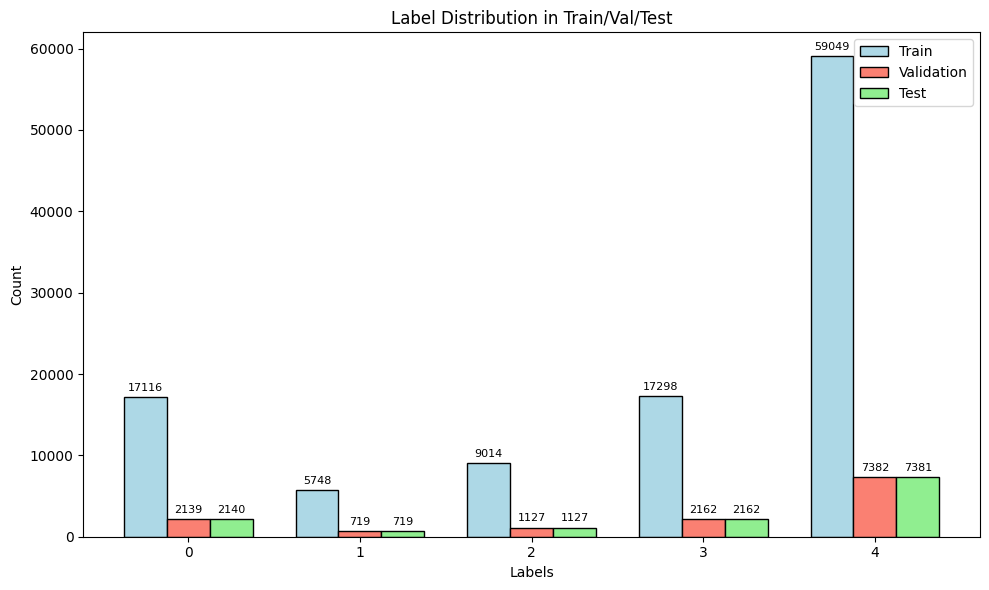

In [ ]:
plot_label_distributions(train_counts, val_counts, test_counts)

### 3.4.2. Checking each set precise statistics - average review length, most popular words for each class and so on


=== Train ===


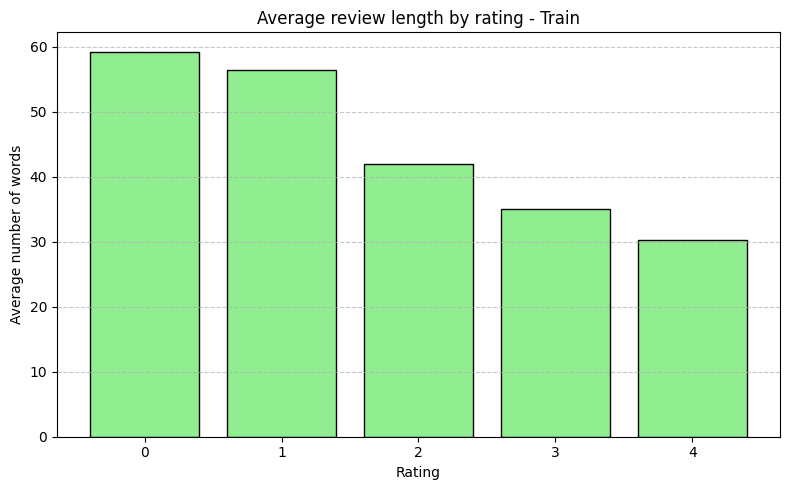

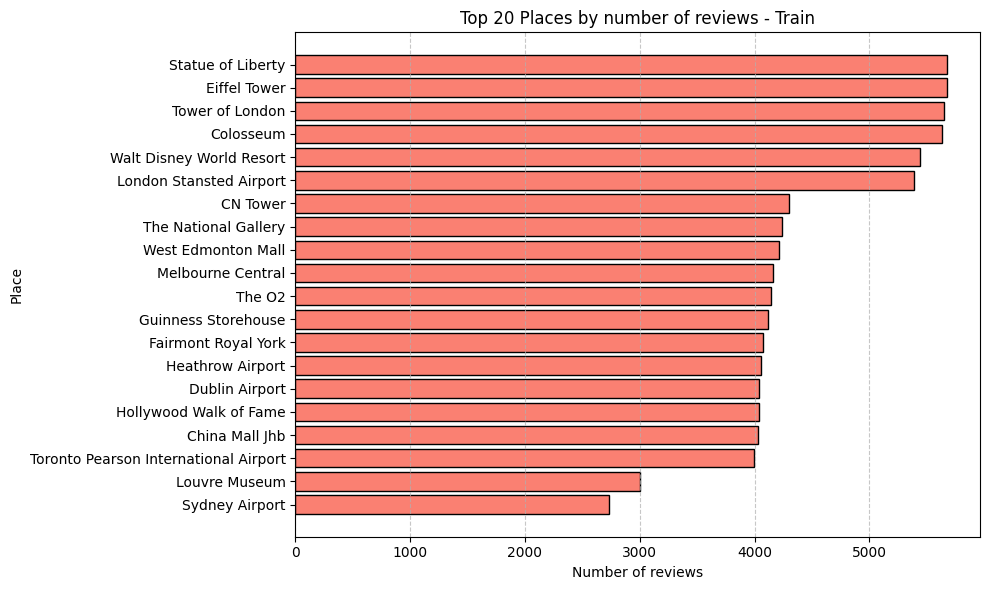

╒═════════╤═════════╤══════════════╕
│ Label   │   Count │ Percentage   │
╞═════════╪═════════╪══════════════╡
│ 0       │   17116 │ 15.82%       │
├─────────┼─────────┼──────────────┤
│ 1       │    5748 │ 5.31%        │
├─────────┼─────────┼──────────────┤
│ 2       │    9014 │ 8.33%        │
├─────────┼─────────┼──────────────┤
│ 3       │   17298 │ 15.98%       │
├─────────┼─────────┼──────────────┤
│ 4       │   59049 │ 54.56%       │
├─────────┼─────────┼──────────────┤
│ Total   │  108225 │ 100.00%      │
╘═════════╧═════════╧══════════════╛
╒═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│ Rating 0        │ Rating 1       │ Rating 2       │ Rating 3       │ Rating 4       │
╞═════════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ airport (4470)  │ get (1336)     │ get (1619)     │ good (3176)    │ great (11361)  │
├─────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ get

In [ ]:
print("\n=== Train ===")

#plot_text_length_distribution(X_train, 'Train')
plot_avg_length_by_rating(texts_train, labels_train, 'Train')
plot_reviews_per_place(places_train, 'Train')
print_label_distribution(labels_train)
print_top_words_per_rating(texts_train, labels_train, stop_words, top_n=10)



=== Validation ===


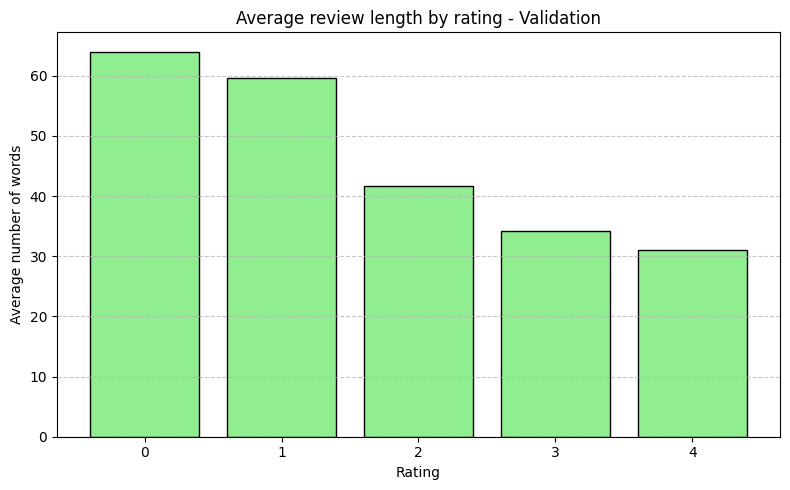

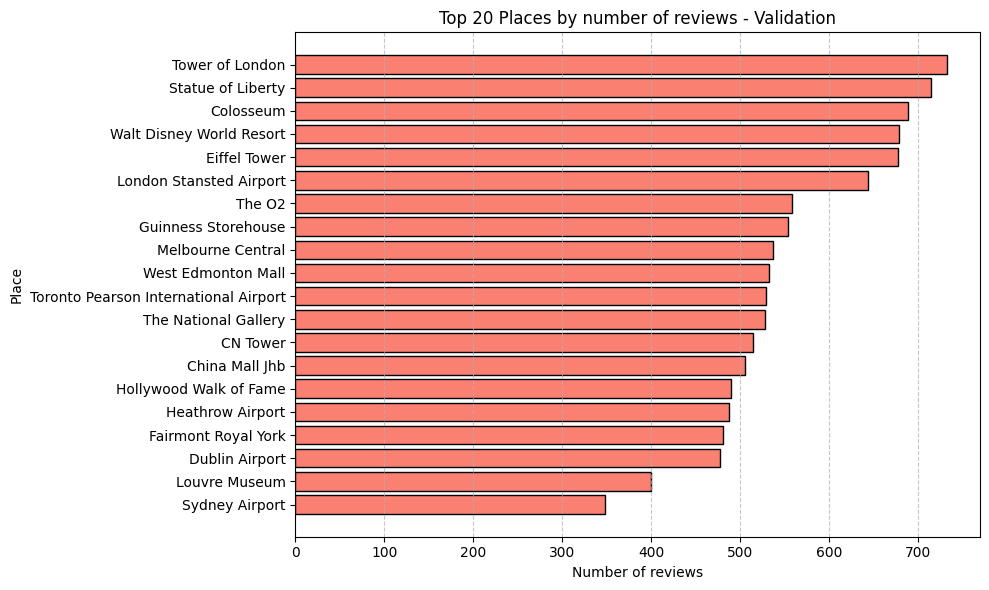

╒═════════╤═════════╤══════════════╕
│ Label   │   Count │ Percentage   │
╞═════════╪═════════╪══════════════╡
│ 0       │    2139 │ 15.81%       │
├─────────┼─────────┼──────────────┤
│ 1       │     719 │ 5.31%        │
├─────────┼─────────┼──────────────┤
│ 2       │    1127 │ 8.33%        │
├─────────┼─────────┼──────────────┤
│ 3       │    2162 │ 15.98%       │
├─────────┼─────────┼──────────────┤
│ 4       │    7382 │ 54.56%       │
├─────────┼─────────┼──────────────┤
│ Total   │   13529 │ 100.00%      │
╘═════════╧═════════╧══════════════╛
╒═══════════════╤════════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Rating 0      │ Rating 1       │ Rating 2      │ Rating 3      │ Rating 4      │
╞═══════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ airport (599) │ get (177)      │ get (186)     │ good (396)    │ great (1425)  │
├───────────────┼────────────────┼───────────────┼───────────────┼───────────────┤
│ get (485)     │ airport (156

In [ ]:
print("\n=== Validation ===")

#plot_text_length_distribution(X_val, 'Validation')
plot_avg_length_by_rating(texts_val, labels_val, 'Validation')
plot_reviews_per_place(places_val, 'Validation')
print_label_distribution(labels_val)
print_top_words_per_rating(texts_val, labels_val, stop_words, top_n=10)



=== Test ===


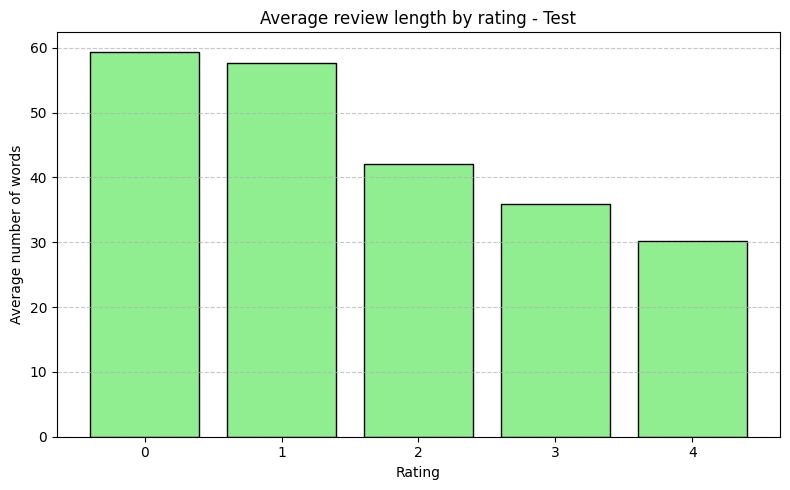

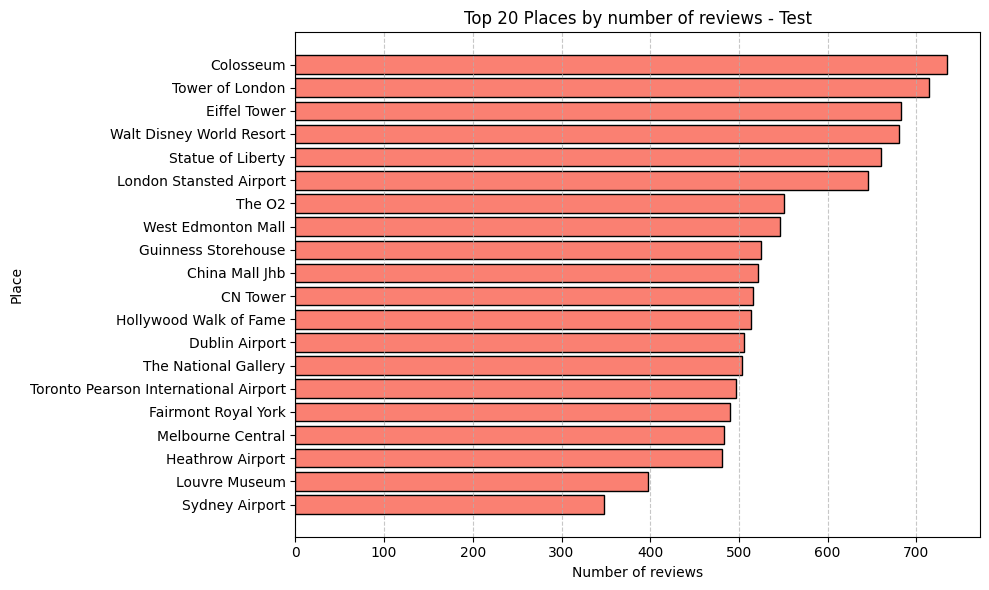

╒═════════╤═════════╤══════════════╕
│ Label   │   Count │ Percentage   │
╞═════════╪═════════╪══════════════╡
│ 0       │    2140 │ 15.82%       │
├─────────┼─────────┼──────────────┤
│ 1       │     719 │ 5.31%        │
├─────────┼─────────┼──────────────┤
│ 2       │    1127 │ 8.33%        │
├─────────┼─────────┼──────────────┤
│ 3       │    2162 │ 15.98%       │
├─────────┼─────────┼──────────────┤
│ 4       │    7381 │ 54.56%       │
├─────────┼─────────┼──────────────┤
│ Total   │   13529 │ 100.00%      │
╘═════════╧═════════╧══════════════╛
╒════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Rating 0       │ Rating 1      │ Rating 2      │ Rating 3      │ Rating 4      │
╞════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ airport (592)  │ get (168)     │ get (216)     │ good (428)    │ great (1415)  │
├────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ one (442)      │ people (152

In [ ]:
print("\n=== Test ===")

#plot_text_length_distribution(X_test, 'Test')
plot_avg_length_by_rating(texts_test, labels_test, 'Test')
plot_reviews_per_place(places_test, 'Test')
print_label_distribution(labels_test)
print_top_words_per_rating(texts_test, labels_test, stop_words, top_n=10)


# 4.Model training

## 4.1. Defining  dataloaders and batch size

In [ ]:
# Adjustable batch size
batch_size_custom = 32

if SAMPLER:
    train_sampler = createSampler(labels_train, num_samples=25000, replacement=True)
else:
    train_sampler = None

if TRAIN and (TRAIN_DISTILBERT or TRAIN_3CLASS_DISTILBERT):
    train_loader_distilbert = DataLoader(train_dataset_distilbert, batch_size=batch_size_custom, shuffle=not SAMPLER, sampler=train_sampler)
    val_loader_distilbert = DataLoader(val_dataset_distilbert, batch_size=batch_size_custom, shuffle=False)

if TRAIN and (TRAIN_RNN or TRAIN_3CLASS_RNN):
    train_loader_rnn = DataLoader(RnnDataset(train_tokens_cleaned, labels_train), batch_size=batch_size_custom, drop_last=True, shuffle=not SAMPLER, sampler=train_sampler)
    val_loader_rnn = DataLoader(RnnDataset(val_tokens_cleaned,labels_val), batch_size=batch_size_custom)

test_loader = DataLoader(test_dataset, batch_size=batch_size_custom, shuffle=False)
test_loader_distilbert = DataLoader(test_dataset_distilbert, batch_size=batch_size_custom, shuffle=False)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=batch_size_custom, shuffle=False)


## 4.2. Model training

### 4.2.1. Inicializing needed models

In [ ]:
if TRAIN and TRAIN_BERT:
    model_bert = BertModel()

if TRAIN and TRAIN_RNN:
    model_rnn = LSTM(
    num_emb=tokenizer.vocab_size,  # 30522 for bert-base-uncased
    output_size=5,                 # for labels 0 to 4
    num_layers=2,                  # one LSTM layer
    hidden_size=128                # size of hidden state
    )

if TRAIN and TRAIN_DISTILBERT:
    model_distilbert = DistilBertModel()

if TRAIN and TRAIN_3CLASS_DISTILBERT:
    model_3class_distilbert = DistilBertModel(num_labels=3)

if TRAIN and TRAIN_3CLASS_RNN:
    model_3class_rnn = LSTM(
    num_emb=tokenizer.vocab_size,  # 30522 for bert-base-uncased
    output_size=3,                 # for labels 0 to 4
    num_layers=2,                  # two LSTM layers
    hidden_size=128                # size of hidden state
    )

### 4.2.2. RNN training (5-classes)

In [ ]:
if TRAIN and TRAIN_RNN:
    print("Training RNN")
    # Only parameters with requires_grad=True will be optimized
    optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
    loss_fct = nn.CrossEntropyLoss()

    num_epochs = 30

    history = train_model(model_rnn, loss_fct, optimizer, train_loader_rnn, val_loader_rnn, num_epochs=num_epochs,early_exit_patience=5)

In [ ]:
if TRAIN and TRAIN_RNN:
    plot_full_training_curves(history)

### 4.2.3 BERT training (NLP town)

In [ ]:
if TRAIN and TRAIN_BERT:
    print("Training BERT")
    # Only parameters with requires_grad=True will be optimized
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_bert.parameters()), lr=1e-5)
    loss_fct = nn.CrossEntropyLoss()

    num_epochs = 40

    history=train_model(model_bert, loss_fct, optimizer, train_loader, val_loader, num_epochs=num_epochs, early_exit_patience=12)

In [ ]:
if TRAIN and TRAIN_BERT:
    plot_full_training_curves(history)

### 4.2.4. DISTILBERT training (5-classes)

In [ ]:
if TRAIN and TRAIN_DISTILBERT:
    print("Training DistilBert")
    # Only parameters with requires_grad=True will be optimized
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_distilbert.parameters()), lr=1e-5)
    loss_fct = nn.CrossEntropyLoss()

    num_epochs = 100

    history=train_model(model_distilbert, loss_fct, optimizer, train_loader_distilbert, val_loader_distilbert, num_epochs=num_epochs, early_exit_patience=12)


In [ ]:
if TRAIN and TRAIN_DISTILBERT:
    plot_full_training_curves(history)

### 4.2.5. DISTILBERT training (3-classes)

In [ ]:
if TRAIN and TRAIN_3CLASS_DISTILBERT:
    print("Training 3-class DistilBert")
    # Only parameters with requires_grad=True will be optimized
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_3class_distilbert.parameters()), lr=1e-5)
    loss_fct = nn.CrossEntropyLoss()

    num_epochs = 100

    history=train_model(model_3class_distilbert, loss_fct, optimizer, train_loader_distilbert, val_loader_distilbert, num_epochs=num_epochs, early_exit_patience=12)


In [ ]:
if TRAIN and TRAIN_3CLASS_DISTILBERT:
  plot_full_training_curves(history)

### 4.2.6. RNN training (6-classes)

In [ ]:
if TRAIN and TRAIN_3CLASS_RNN:
    print("Training 3-class RNN")
    # Only parameters with requires_grad=True will be optimized
    optimizer = torch.optim.Adam(model_3class_rnn.parameters(), lr=1e-3)
    loss_fct = nn.CrossEntropyLoss()

    num_epochs = 30

    history = train_model(model_3class_rnn, loss_fct, optimizer, train_loader_rnn, val_loader_rnn, num_epochs=num_epochs,early_exit_patience=None)

In [ ]:
if TRAIN and TRAIN_3CLASS_RNN:
  plot_full_training_curves(history)

# 5.Model loading and evaluation

## 5.1. All trained model loading

In [ ]:
evaluation_models_data = {}

### 5.1.1. Load sampler models

In [ ]:
if EVAL_MODE and SAMPLER:

    model_rnn_sampler = LSTM(
        num_emb=tokenizer.vocab_size,
        output_size=5,
        num_layers=2,
        hidden_size=128
    )
    loadWeights(model_rnn_sampler, RNN_PATH_SAMPLER, "rnn_sampler.pt")
    model_rnn_sampler.eval()

    model_bert_sampler = BertModel(freeze=False)
    loadWeights(model_bert_sampler, BERT_PATH_SAMPLER, "bert_sampler.pt")
    model_bert_sampler.eval()

    model_distilbert_sampler = DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_sampler, DISTILBERT_PATH_SAMPLER, "distilbert_sampler.pt")
    model_distilbert_sampler.eval()

    evaluation_models_data.update({
        "RNN (sampler)": (model_rnn_sampler, test_loader_rnn),
        "BERT (sampler)": (model_bert_sampler, test_loader),
        "DistilBERT (sampler)": (model_distilbert_sampler, test_loader_distilbert)
    })

### 5.1.2. Load fullset models

In [ ]:
if EVAL_MODE and FULL_SET and not SAMPLER:

    model_rnn_fullset = LSTM(
        num_emb=tokenizer.vocab_size,
        output_size=5,
        num_layers=2,
        hidden_size=128
    )
    loadWeights(model_rnn_fullset, RNN_PATH_FULLSET, "rnn_fullset.pt")
    model_rnn_fullset.eval()

    model_bert_fullset = BertModel(freeze=False)
    loadWeights(model_bert_fullset, BERT_PATH_FULLSET, "bert_fullset.pt")
    model_bert_fullset.eval()

    model_distilbert_fullset = DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_fullset, DISTILBERT_PATH_FULLSET, "distilbert_fullset.pt")
    model_distilbert_fullset.eval()

    evaluation_models_data.update({
        "RNN (fullset)": (model_rnn_fullset, test_loader_rnn),
        "BERT (fullset)": (model_bert_fullset, test_loader),
        "DistilBERT (fullset)": (model_distilbert_fullset, test_loader_distilbert)
    })


Loading weights from https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/rnn_fullset_0.5186.pt...


100%|██████████| 52.7M/52.7M [00:00<00:00, 211MB/s]


Weights loaded!


Loading weights from https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/bert_fullset_0.5205.pt...


100%|██████████| 639M/639M [00:15<00:00, 42.7MB/s]


Weights loaded!


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading weights from https://huggingface.co/AlexaWal2025/LT_FINAL_PROJECT/resolve/main/distilbert_fullset_0.5572.pt...


100%|██████████| 255M/255M [00:07<00:00, 36.4MB/s]


Weights loaded!


### 5.1.3. Load 3-class models

In [ ]:
if EVAL_MODE and THREE_CLASS:

    model_rnn_3class = LSTM(
        num_emb=tokenizer.vocab_size,
        output_size=3,
        num_layers=2,
        hidden_size=128
    )
    loadWeights(model_rnn_3class, RNN_PATH_THREE_CLASS, "rnn_3class.pt")
    model_rnn_3class.eval()

    # BERT model not usually used for 3-class, but load if path is available
    if BERT_PATH_THREE_CLASS is not None:
        model_bert_3class = BertModel(freeze=False)
        loadWeights(model_bert_3class, BERT_PATH_THREE_CLASS, "bert_3class.pt")
        model_bert_3class.eval()

        evaluation_models_data.update({
            "BERT (3-class)": (model_bert_3class, test_loader)
        })

    model_distilbert_3class = DistilBertModel(num_labels=3)
    loadWeights(model_distilbert_3class, DISTILBERT_PATH_THREE_CLASS, "distilbert_3class.pt")
    model_distilbert_3class.eval()

    evaluation_models_data.update({
        "RNN (3-class)": (model_rnn_3class, test_loader_rnn),
        "DistilBERT (3-class)": (model_distilbert_3class, test_loader_distilbert)
    })


### 5.1.4. Load 25/5/5 models

In [ ]:
if EVAL_MODE and SET_25:

    model_rnn_25set = LSTM(
        num_emb=tokenizer.vocab_size,
        output_size=5,
        num_layers=2,
        hidden_size=128
    )
    loadWeights(model_rnn_25set, RNN_PATH_SET_25, "rnn_25set.pt")
    model_rnn_25set.eval()

    model_bert_25set = BertModel(freeze=False)
    loadWeights(model_bert_25set, BERT_PATH_SET_25, "bert_25set.pt")
    model_bert_25set.eval()

    model_distilbert_25set = DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_25set, DISTILBERT_PATH_SET_25, "distilbert_25set.pt")
    model_distilbert_25set.eval()

    evaluation_models_data.update({
        "RNN (25/5/5)": (model_rnn_25set, test_loader_rnn),
        "BERT (25/5/5)": (model_bert_25set, test_loader),
        "DistilBERT (25/5/5)": (model_distilbert_25set, test_loader_distilbert)
    })


### 5.1.5. Load baseline bert (nlp-town) model

In [ ]:
# Baseline model
if not THREE_CLASS:
    base_bert_model = BertModel(freeze=False)
    base_bert_model.eval()

    evaluation_models_data.update({
        "Base NLP Town BERT": (base_bert_model, test_loader)
    })

## 5.2. Model evaluation

In [ ]:
# Run the models on test dataset
if EVAL_MODE:
    if THREE_CLASS:
        texts = test_dataset_distilbert.raw_texts
        true_labels = test_dataset_distilbert.labels
    else:
        texts = test_dataset.raw_texts
        true_labels = test_dataset.labels

    evaluation_model_predictions = {}
    # Test models
    for model_name, (model, test_loader) in evaluation_models_data.items():
        print(f"Evaluating {model_name}")
        preds = test(model, test_loader)
        evaluation_model_predictions[model_name] = preds


Evaluating RNN (fullset)
Device: cuda


Testing: 100%|██████████| 423/423 [00:01<00:00, 269.88it/s]


Evaluating BERT (fullset)
Device: cuda


Testing: 100%|██████████| 423/423 [01:22<00:00,  5.15it/s]


Evaluating DistilBERT (fullset)
Device: cuda


Testing: 100%|██████████| 423/423 [00:46<00:00,  9.14it/s]


Evaluating Base NLP Town BERT
Device: cuda


Testing: 100%|██████████| 423/423 [01:30<00:00,  4.68it/s]


### 5.2.1. Metrics comparison

In [ ]:
if EVAL_MODE:
    metrics_comp_df = compare_metrics(true_labels, evaluation_model_predictions)
    display(metrics_comp_df.style.format("{:.3f}"))

,Accuracy,Off-by-1 accuracy,Macro Precision,Macro Recall,Macro F1-score,Weighted Precision,Weighted Recall,Weighted F1-score
Model,,,,,,,,
RNN (fullset),0.700,0.921,0.521,0.512,0.511,0.677,0.700,0.684
BERT (fullset),0.692,0.926,0.542,0.519,0.523,0.684,0.692,0.685
DistilBERT (fullset),0.726,0.944,0.570,0.550,0.557,0.712,0.726,0.717
Base NLP Town BERT,0.636,0.911,0.503,0.537,0.515,0.679,0.636,0.653


In [ ]:
for model_name, preds in evaluation_model_predictions.items():
    print(f"{model_name} classification report")
    print(classification_report(true_labels, preds))

RNN (fullset) classification report
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2140
           1       0.28      0.22      0.25       719
           2       0.33      0.37      0.35      1127
           3       0.43      0.27      0.33      2162
           4       0.82      0.89      0.86      7381

    accuracy                           0.70     13529
   macro avg       0.52      0.51      0.51     13529
weighted avg       0.68      0.70      0.68     13529

BERT (fullset) classification report
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2140
           1       0.34      0.28      0.31       719
           2       0.38      0.19      0.26      1127
           3       0.41      0.49      0.45      2162
           4       0.82      0.84      0.83      7381

    accuracy                           0.69     13529
   macro avg       0.54      0.52      0.52     13529
weig

### 5.2.2. Confusion matrix

RNN (fullset) confusion matrix


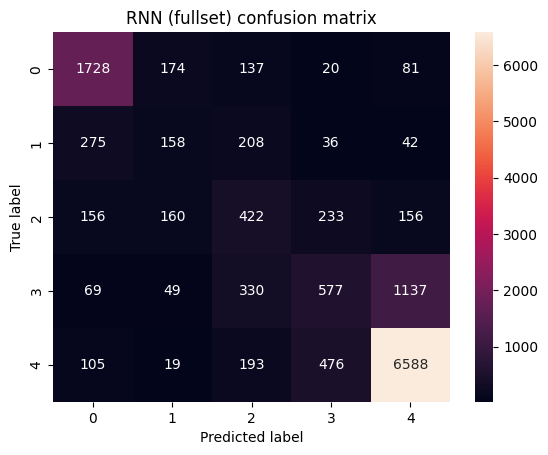

BERT (fullset) confusion matrix


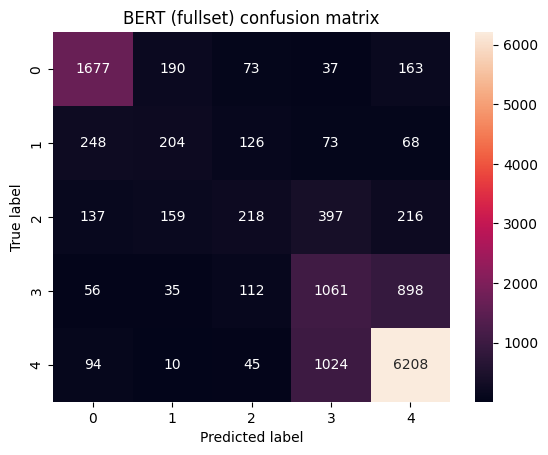

DistilBERT (fullset) confusion matrix


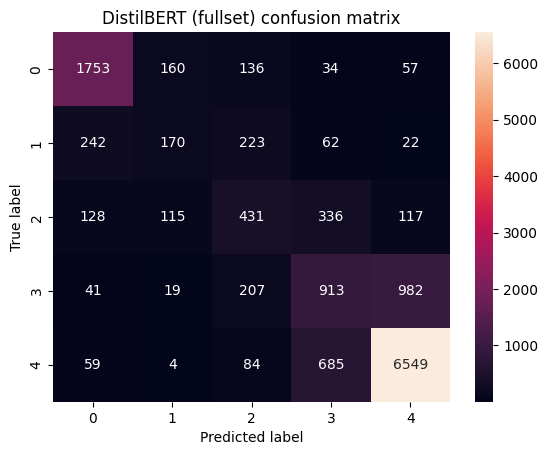

Base NLP Town BERT confusion matrix


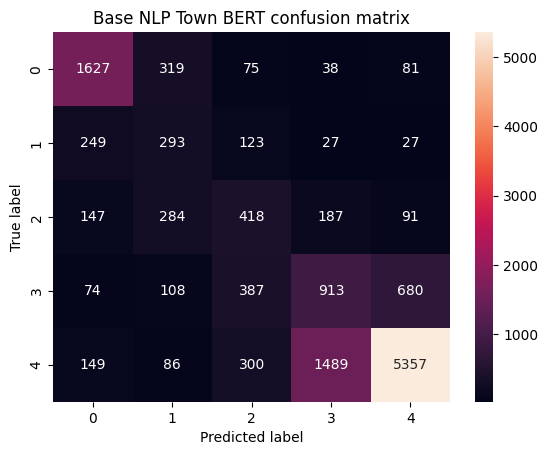

In [ ]:
if EVAL_MODE:
    for model_name, preds in evaluation_model_predictions.items():
        print(f"{model_name} confusion matrix")
        plot_confusion_matrix(true_labels, preds, model_name)

## 5.3. Random selection test

In [ ]:
if EVAL_MODE:
    indices = select_filtered_examples(true_labels, evaluation_model_predictions, filter_type="none", num_examples=5)
    show_comparison_examples(texts, true_labels, evaluation_model_predictions, indices)

Example 8466
----------------------------------------------------------------------------------------------------
Text: Expensive! After reading the reviews on google decided not to order further. 2 espresso for $9.36!
True Label: 0
Correct Predictions: RNN (fullset), BERT (fullset), DistilBERT (fullset), Base NLP Town BERT
Model Predictions:
RNN (fullset): 0 ✅
BERT (fullset): 0 ✅
DistilBERT (fullset): 0 ✅
Base NLP Town BERT: 0 ✅
Example 4281
----------------------------------------------------------------------------------------------------
Text: A wonderful place to visit, very clean and organized. I love it
True Label: 4
Correct Predictions: RNN (fullset), BERT (fullset), DistilBERT (fullset), Base NLP Town BERT
Model Predictions:
RNN (fullset): 4 ✅
BERT (fullset): 4 ✅
DistilBERT (fullset): 4 ✅
Base NLP Town BERT: 4 ✅
Example 7168
----------------------------------------------------------------------------------------------------
Text: Very efficient
True Label: 4
Correct Prediction

### 5.3.1. What all models predicted correctly

In [ ]:
if EVAL_MODE:
    indices = select_filtered_examples(true_labels, evaluation_model_predictions, filter_type="tp", num_examples=5)
    show_comparison_examples(texts, true_labels, evaluation_model_predictions, indices)

Example 9985
----------------------------------------------------------------------------------------------------
Text: Lots of stores. Parking is horrible. You just have to stalk people leaving the building in your car and it gets awkward. We only go if we have to, like most Edmontonians. Great for out of town guests. Free the seals! There's also a chick fil a now, it's fine.
True Label: 3
Correct Predictions: RNN (fullset), BERT (fullset), DistilBERT (fullset), Base NLP Town BERT
Model Predictions:
RNN (fullset): 3 ✅
BERT (fullset): 3 ✅
DistilBERT (fullset): 3 ✅
Base NLP Town BERT: 3 ✅
Example 13010
----------------------------------------------------------------------------------------------------
Text: Impressive building but the dirt and dodgy traders and ridiculous tourist rip-offs just spoil it. Better to take photos from further away and enjoy it without all the hassle you get up close. And don’t even consider the Trocadero…while it’s a good photo shot, it’s just as crowded and

### 5.3.2. What models disagree on

In [ ]:
if EVAL_MODE:
    indices = select_filtered_examples(true_labels, evaluation_model_predictions, filter_type="disagree", num_examples=5)
    show_comparison_examples(texts, true_labels, evaluation_model_predictions, indices)

Example 6078
----------------------------------------------------------------------------------------------------
Text: There are so many cheap flights from this airport. But airport is always busy specially in school holidays, so make sure you have enough time to catch your flight. Down side is the dirty toilets, not even single time we found clean toilets.
True Label: 2
Correct Predictions: RNN (fullset), DistilBERT (fullset), Base NLP Town BERT
Model Predictions:
RNN (fullset): 2 ✅
BERT (fullset): 3 ❌
DistilBERT (fullset): 2 ✅
Base NLP Town BERT: 2 ✅
Example 11136
----------------------------------------------------------------------------------------------------
Text: Decent sized room. Housekeeping/cleaning service was not good, had to call multiple times to get rooms cleaned/bring up more blankets and still neither ended up happening. Managerial positions were unapologetic. "Resort fee" of $22 per night is silly considering the hotel is so old. Having two bathrooms in the suite w

### 5.3.3 False positive results random selection

In [ ]:
indices = select_filtered_examples(true_labels, evaluation_model_predictions, filter_type="fp_main", num_examples=5) # main is first model in evaluation_model_predictions
show_comparison_examples(texts, true_labels, evaluation_model_predictions, indices)

Example 12125
----------------------------------------------------------------------------------------------------
Text: Not much of shops but it has all of what you want
True Label: 2
Correct Predictions: Base NLP Town BERT
Model Predictions:
RNN (fullset): 3 ❌
BERT (fullset): 4 ❌
DistilBERT (fullset): 3 ❌
Base NLP Town BERT: 2 ✅
Example 9496
----------------------------------------------------------------------------------------------------
Text: Huge b&q store with a great range of items. They have a trade point for registered builders and recently I noticed they have an area to hire tools.
True Label: 4
Correct Predictions: DistilBERT (fullset), Base NLP Town BERT
Model Predictions:
RNN (fullset): 3 ❌
BERT (fullset): 3 ❌
DistilBERT (fullset): 4 ✅
Base NLP Town BERT: 4 ✅
Example 1386
----------------------------------------------------------------------------------------------------
Text: Tiny small, but nice, few stores, Mcdonalds, enough
True Label: 4
Correct Predictions: None
Mod

### 5.3.4. What no model could predict correctly

In [ ]:
if EVAL_MODE:
    indices = select_filtered_examples(true_labels, evaluation_model_predictions, filter_type="fp", num_examples=5) # fp for all
    show_comparison_examples(texts, true_labels, evaluation_model_predictions, indices)

Example 1253
----------------------------------------------------------------------------------------------------
Text: I would say it's looking awesome but the looks are changed now because they maintained it in that manner.
True Label: 3
Correct Predictions: BERT (fullset), DistilBERT (fullset)
Model Predictions:
RNN (fullset): 2 ❌
BERT (fullset): 3 ✅
DistilBERT (fullset): 3 ✅
Base NLP Town BERT: 2 ❌
Example 10281
----------------------------------------------------------------------------------------------------
Text: Dropped off at T5, there were plenty of trollies available, as well as quite a bit of police presence. As we dropped off there's a £5 charge to do so, I personally think it's ludicrous this can be charged.
True Label: 3
Correct Predictions: None
Model Predictions:
RNN (fullset): 2 ❌
BERT (fullset): 4 ❌
DistilBERT (fullset): 2 ❌
Base NLP Town BERT: 1 ❌
Example 12705
----------------------------------------------------------------------------------------------------
Text

# 6.Extra: Model manual testing for 5 stars

In [ ]:
if EVAL_MODE:
    label_names = ["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]

    test_model_manual(
        evaluation_models_data,
        label_names=label_names,
        device="cpu"
    )

# 7.Extra: Random testing set for distilberts

In [ ]:
import kagglehub

path = kagglehub.dataset_download("denizbilginn/google-maps-restaurant-reviews")
!cp -r /root/.cache/kagglehub/datasets/denizbilginn/google-maps-restaurant-reviews/versions/4 /content/google_maps_restaurant_reviews


100%|██████████| 657M/657M [00:18<00:00, 36.6MB/s]

Extracting files...


In [ ]:
# Load the file as a DataFrame
df = pd.read_csv('/content/google_maps_restaurant_reviews/reviews.csv')

# Keep only 'textx' and 'labels' columns
df = df[['text', 'rating', "business_name"]]

# Display the resulting DataFrame
print(df.head())

                                                text  rating  \
0  We went to Marmaris with my wife for a holiday...       5   
1  During my holiday in Marmaris we ate here to f...       4   
2  Prices are very affordable. The menu in the ph...       3   
3  Turkey's cheapest artisan restaurant and its f...       5   
4  I don't know what you will look for in terms o...       3   

                     business_name  
0  Haci'nin Yeri - Yigit Lokantasi  
1  Haci'nin Yeri - Yigit Lokantasi  
2  Haci'nin Yeri - Yigit Lokantasi  
3  Haci'nin Yeri - Yigit Lokantasi  
4  Haci'nin Yeri - Yigit Lokantasi  


In [ ]:
import pandas as pd
from transformers import DistilBertTokenizerFast
import torch
from sklearn.preprocessing import LabelEncoder

labels = torch.tensor(df['rating'] - 1)  # rating: 1-5 → label: 0-4, so rating-1 works

le = LabelEncoder()
places_encoded = le.fit_transform(df['business_name'])
places = torch.tensor(places_encoded)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokens = tokenize_texts(list(df['text']),tokenizer)
texts = list(df['text'])
test_dataset_extra = ReviewsDataset(tokens, texts, labels, places)
test_loader_extra = DataLoader(test_dataset_extra, batch_size=32, shuffle=False)



In [ ]:
if EVAL_MODE and EXTRA_TEST:
    model_distilbert_fullset =  DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_fullset, DISTILBERT_PATH_FULLSET, "distilbert_fullset.pt")
    model_distilbert_fullset.eval()

    model_distilbert_sampler = DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_sampler, DISTILBERT_PATH_SAMPLER, "distilbert_sampler.pt")
    model_distilbert_sampler.eval()

    model_distilbert_25set =  DistilBertModel(num_labels=5)
    loadWeights(model_distilbert_25set, DISTILBERT_PATH_SET_25, "distilbert_25set.pt")
    model_distilbert_25set.eval()


In [ ]:
if EVAL_MODE:
    if EXTRA_TEST:
        texts = test_dataset_extra.raw_texts
        true_labels = test_dataset_extra.labels
        test_loader_extra = DataLoader(test_dataset_extra, batch_size=32, shuffle=False)

        preds_distilbert_fullset = test(model_distilbert_fullset, test_loader_extra)
        preds_distilbert_sampler = test(model_distilbert_sampler, test_loader_extra)
        preds_distilbert_25set = test(model_distilbert_25set, test_loader_extra)


In [ ]:
if EVAL_MODE:
    if EXTRA_TEST:
        evaluation_model_predictions = {
            "Fullset DistilBERT": preds_distilbert_fullset,
            "Sampler DistilBERT": preds_distilbert_sampler,
            "25_SET DistilBERT ": preds_distilbert_25set,
        }

In [ ]:
if EVAL_MODE and EXTRA_TEST:
    metrics_comp_df = compare_metrics(true_labels, evaluation_model_predictions)
    display(metrics_comp_df.style.format("{:.3f}"))

In [ ]:
if EVAL_MODE:
    for model_name, preds in evaluation_model_predictions.items():
        print(f"{model_name} classification report")
        print(classification_report(true_labels, preds))